# Definitive Merger of Startup Databases

This notebook merges the startup anagrafica dataset with the crunchbase dataset using fuzzy matching on company names.

In [1]:
import pandas as pd
import numpy as np
import re
from thefuzz import process, fuzz
from src.ingestion import download_from_drive
from tqdm.notebook import tqdm

In [4]:
# set names
df_non_unite = "df_da_unire_2.csv"
# Ensure the file path is correct or update it to the correct location
df_crunchbase = pd.read_csv('data/df_da_unire.csv')  # Adjust the path as needed
df_aida = download_from_drive("aida_2018_descrizione")

In [7]:
# Load the databases
df_anagrafica = df_aida
#df_anagrafica = download_from_drive("csv_startup_anagrafica")
#df_crunchbase = download_from_drive("estrazione_crunchbase_5k")

# Display the first few rows of each dataframe
print("Startup Anagrafica Dataset:")
display(df_anagrafica.head())

print("\nCrunchbase Dataset:")
display(df_crunchbase.head())

Startup Anagrafica Dataset:


,Unnamed: 0,Ragione sociale,BvD ID number,Codice fiscale,Numero CCIAA,Partita IVA,Indirizzo sede legale,Provincia,Indirizzo sede legale - Codice postale,Indirizzo sede legale - Regione,Sede operativa,Sede operativa - Provincia,Sede operativa - Codice postale,Sede operativa - Regione - Regione,ATECO 2007\ncodice,Anno di costituzione,Fondazione,Stato giuridico,Forma giuridica
0,1.0,ADI SERVIZI MARITTIMI S.R.L.,IT10354920968,10354920968,MI2525097,1.035492e+10,"VLE CERTOSA, 239",Milano,20151.0,Lombardia,VIALE CERTOSA 239,Milano,20151.0,LOMBARDIA,502000.0,18/05/2018,NaN,Attiva (Stato di insolvenza),S.R.L.
1,2.0,ACCIAIERIE D'ITALIA S.P.A.,IT10354890963,10354890963,MI2525101,1.035489e+10,"VLE CERTOSA, 239",Milano,20151.0,Lombardia,VIALE CERTOSA 239,Milano,20151.0,LOMBARDIA,241000.0,18/05/2018,NaN,Attiva (Stato di insolvenza),S.P.A.
2,3.0,ADI ENERGIA S.R.L.,IT10354910969,10354910969,MI2525096,1.035491e+10,"VLE CERTOSA, 239",Milano,20151.0,Lombardia,VIALE CERTOSA 239,Milano,20151.0,LOMBARDIA,351100.0,18/05/2018,NaN,Attiva (Stato di insolvenza),S.R.L.
3,4.0,TECUM SOCIETA' COOPERATIVA SOCIALE,IT15907261000,15907261000,RM1622339,1.590726e+10,"PZA VITTORIO EMANUELE II, 138",Roma,185.0,Lazio,NaN,NaN,NaN,NaN,881000.0,03/11/2020,NaN,In liquidazione,S.C.A.R.L.P.A.
4,5.0,ITALMETAL GROUP SRL IN LIQUIDAZIONE,IT14825331003,14825331003,PR0285439,1.482533e+10,"PZA SISTO ROSA BADALOCCHIO, 9/B",Parma,43126.0,Emilia-Romagna,PIAZZA SISTO ROSA BADALOCCHIO 9/B,Parma,43126.0,EMILIA-ROMAGNA,479110.0,01/06/2018,NaN,In liquidazione,S.R.L.



Crunchbase Dataset:


,Organization Name
0,#00F Agency
1,(re)BALANCE
2,010 Films
3,01Bee
4,1000Farmacie


In [ ]:
# fuzzymerge
def pulisci_stringa(s: str) -> str:
    """
    Enhanced string cleaning function with more sophisticated preprocessing
    for better company name matching.
    """
    if not isinstance(s, str):
        if s is None:
            return ""
        else:
            return str(s)
    
    s = s.strip().lower()
    
    # Handle common company type abbreviations (more comprehensive list)
    s = re.sub(r'\b(srl|s\.r\.l|s\.r\.l\.|s.r.l|spa|s\.p\.a|s\.p\.a\.|s.p.a|' + 
               r'inc|incorporated|llc|ltd|limited|gmbh|' + 
               r'corp|corporation|co\.|company|group|holding|' + 
               r'sas|sapa|snc|scarl)(?=\s|$|\b)', '', s)
    
    # Handle common abbreviations
    s = s.replace("int'l", "international")
    s = s.replace("tech.", "technology")
    s = s.replace("tech", "technology")
    s = s.replace("&", "and")
    
    # Remove geographical designations that might differ
    s = re.sub(r'\b(italy|italia|italian|italiano|italiana)\b', '', s)
    
    # Remove special characters and extra spaces
    s = re.sub(r'[^\w\s]', ' ', s)
    
    # Remove common filler words
    s = re.sub(r'\b(the|di|del|della|e|a|in|for|of)\b', ' ', s)
    
    # Replace multiple spaces with single space and trim
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

def calculate_composite_score(name1, name2):
    """
    Calculate a composite score using multiple string matching algorithms
    to better identify company name matches.
    
    Returns: float between 0-100 representing match confidence
    """
    # Standard ratios check different aspects of string similarity
    ratio = fuzz.ratio(name1, name2)
    partial_ratio = fuzz.partial_ratio(name1, name2)
    token_sort_ratio = fuzz.token_sort_ratio(name1, name2)
    token_set_ratio = fuzz.token_set_ratio(name1, name2)
    
    # Calculate a weighted average - giving more weight to token methods
    # as they handle word order differences better for company names
    weighted_score = (
        ratio * 0.15 +
        partial_ratio * 0.25 +
        token_sort_ratio * 0.3 +
        token_set_ratio * 0.3
    )
    
    # Additional bonus for exact token matching
    tokens1 = set(name1.split())
    tokens2 = set(name2.split())
    
    # If there are significant shared tokens, boost the score
    if len(tokens1) > 0 and len(tokens2) > 0:
        shared = tokens1.intersection(tokens2)
        if len(shared) >= 2:  # At least 2 significant words match
            weighted_score += min(10, len(shared) * 2.5)  # Bonus up to 10 points
    
    # Cap at 100
    return min(100, weighted_score)

def enhanced_fuzzy_merge(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    key1: str,
    key2: str,
    threshold: int = 75
) -> pd.DataFrame:
    """
    Enhanced version of fuzzy_merge that uses multiple matching techniques
    for more accurate company name matching.
    """
    # Copia dei DataFrame per non modificare gli originali
    df1_clean = df1.copy()
    df2_clean = df2.copy()
    
    # Creiamo colonne "pulite" per il matching con la funzione migliorata
    df1_clean['key_clean'] = df1_clean[key1].apply(pulisci_stringa)
    df2_clean['key_clean'] = df2_clean[key2].apply(pulisci_stringa)
    
    # Create clean keys and make a dictionary for lookup
    unique_keys2 = df2_clean['key_clean'].unique().tolist()
    
    # Lista per salvare i risultati
    risultati = []
    
    # Track already matched names in df2 to avoid duplicates
    matched_df2_indices = set()

    for idx1, row in tqdm(df1_clean.iterrows(), total=len(df1_clean), desc="Matching records"):
        name_to_match = row['key_clean']
        
        # Skip empty names
        if not name_to_match.strip():
            continue
            
        # Get top 5 potential matches instead of just one
        top_matches = process.extract(name_to_match, unique_keys2, 
                                     scorer=fuzz.token_set_ratio, limit=5)
        
        best_match = None
        best_score = 0
        best_match_row = None
        
        # Evaluate each potential match with our composite score
        for match_name, base_score in top_matches:
            # Calculate more sophisticated score
            composite_score = calculate_composite_score(name_to_match, match_name)
            
            # Find matching rows
            match_rows = df2_clean[df2_clean['key_clean'] == match_name]
            
            # Skip if we've already used all these matches
            if all(idx in matched_df2_indices for idx in match_rows.index):
                continue
                
            # Get first available match
            for idx2, match_row in match_rows.iterrows():
                if idx2 not in matched_df2_indices and composite_score > best_score:
                    best_score = composite_score
                    best_match = match_name
                    best_match_row = match_row
                    best_match_idx = idx2
                    break
        
        # Process the best match if it meets the threshold
        if best_match and best_score >= threshold:
            # Mark this df2 row as matched
            matched_df2_indices.add(best_match_idx)
            
            # Build combined data dictionary
            combined_data = {}
            
            # Data from df1
            for col in df1_clean.columns:
                if col != 'key_clean':  # Exclude auxiliary column
                    combined_data[f"anagrafica_{col}"] = row[col]
            
            # Data from df2
            for col in df2_clean.columns:
                if col != 'key_clean':  # Exclude auxiliary column
                    combined_data[f"crunchbase_{col}"] = best_match_row[col]
            
            combined_data['similarity_score'] = best_score
            combined_data['composite_match'] = True
            
            risultati.append(combined_data)
        else:
            # If no good match, keep just df1 data
            combined_data = {}
            for col in df1_clean.columns:
                if col != 'key_clean':
                    combined_data[f"anagrafica_{col}"] = row[col]
            
            for col in df2_clean.columns:
                if col != 'key_clean':
                    combined_data[f"crunchbase_{col}"] = None
                    
            combined_data['similarity_score'] = best_score if best_score else 0
            combined_data['composite_match'] = False
            risultati.append(combined_data)
    
    # Add remaining df2 rows that weren't matched
    if len(matched_df2_indices) < len(df2_clean):
        for idx2, row in df2_clean.iterrows():
            if idx2 not in matched_df2_indices:
                combined_data = {}
                
                # Empty df1 data
                for col in df1_clean.columns:
                    if col != 'key_clean':
                        combined_data[f"anagrafica_{col}"] = None
                
                # df2 data
                for col in df2_clean.columns:
                    if col != 'key_clean':
                        combined_data[f"crunchbase_{col}"] = row[col]
                
                combined_data['similarity_score'] = 0
                combined_data['composite_match'] = False
                risultati.append(combined_data)
    
    # Convert to DataFrame
    df_risultati = pd.DataFrame(risultati)
    return df_risultati

In [ ]:
# Merging
# Ensure ipywidgets is installed to fix the IProgress error
#%pip install ipywidgets

# Eseguiamo il merge con una soglia appropriata
df_merged = enhanced_fuzzy_merge(df_anagrafica, df_crunchbase, "Ragione sociale", "Organization Name", threshold=85)

# Visualizziamo un campione dei risultati
print(f"Numero di record totali dopo il merge: {len(df_merged)}")
df_merged.head()

Note: you may need to restart the kernel to use updated packages.


Matching records:   0%|          | 0/6566 [00:00<?, ?it/s]

Numero di record totali dopo il merge: 9703


,anagrafica_Unnamed: 0,anagrafica_Ragione sociale,anagrafica_BvD ID number,anagrafica_Codice fiscale,anagrafica_Numero CCIAA,anagrafica_Partita IVA,anagrafica_Indirizzo sede legale,anagrafica_Provincia,anagrafica_Indirizzo sede legale - Codice postale,anagrafica_Indirizzo sede legale - Regione,...,anagrafica_Sede operativa - Codice postale,anagrafica_Sede operativa - Regione - Regione,anagrafica_ATECO 2007\ncodice,anagrafica_Anno di costituzione,anagrafica_Fondazione,anagrafica_Stato giuridico,anagrafica_Forma giuridica,crunchbase_Organization Name,similarity_score,composite_match
0,1.0,ADI SERVIZI MARITTIMI S.R.L.,IT10354920968,1.035492e+10,MI2525097,1.035492e+10,"VLE CERTOSA, 239",Milano,20151.0,Lombardia,...,20151.0,LOMBARDIA,502000.0,18/05/2018,NaN,Attiva (Stato di insolvenza),S.R.L.,None,69.10,False
1,2.0,ACCIAIERIE D'ITALIA S.P.A.,IT10354890963,1.035489e+10,MI2525101,1.035489e+10,"VLE CERTOSA, 239",Milano,20151.0,Lombardia,...,20151.0,LOMBARDIA,241000.0,18/05/2018,NaN,Attiva (Stato di insolvenza),S.P.A.,None,60.50,False
2,3.0,ADI ENERGIA S.R.L.,IT10354910969,1.035491e+10,MI2525096,1.035491e+10,"VLE CERTOSA, 239",Milano,20151.0,Lombardia,...,20151.0,LOMBARDIA,351100.0,18/05/2018,NaN,Attiva (Stato di insolvenza),S.R.L.,None,83.00,False
3,4.0,TECUM SOCIETA' COOPERATIVA SOCIALE,IT15907261000,1.590726e+10,RM1622339,1.590726e+10,"PZA VITTORIO EMANUELE II, 138",Roma,185.0,Lazio,...,NaN,NaN,881000.0,03/11/2020,NaN,In liquidazione,S.C.A.R.L.P.A.,None,67.75,False
4,5.0,ITALMETAL GROUP SRL IN LIQUIDAZIONE,IT14825331003,1.482533e+10,PR0285439,1.482533e+10,"PZA SISTO ROSA BADALOCCHIO, 9/B",Parma,43126.0,Emilia-Romagna,...,43126.0,EMILIA-ROMAGNA,479110.0,01/06/2018,NaN,In liquidazione,S.R.L.,None,52.15,False


In [10]:
# Creiamo un ID unico per ogni coppia abbinata
# Utilizziamo una combinazione dei valori originali per creare un ID significativo

def create_unique_id(row):
    # Prendiamo il nome dalla colonna anagrafica se disponibile, altrimenti da crunchbase
    company_name = str(row['anagrafica_Ragione sociale']) if pd.notna(row['anagrafica_Ragione sociale']) else \
                  str(row['crunchbase_Organization Name']) if pd.notna(row['crunchbase_Organization Name']) else 'unknown'
    
    # Pulizia base per l'ID
    clean_name = re.sub(r'[^\w]', '', company_name.lower())
    
    # Aggiungiamo un valore numerico progressivo per garantire l'unicità
    return f"comp_{clean_name[:20]}"

# Creiamo inizialmente l'ID senza controllo duplicati
df_merged['company_id'] = df_merged.apply(create_unique_id, axis=1)

# Controlliamo e gestiamo i duplicati aggiungendo un numero progressivo
id_counts = df_merged['company_id'].value_counts()
duplicated_ids = id_counts[id_counts > 1].index.tolist()

# Per ogni ID duplicato, aggiungiamo un contatore
for dup_id in duplicated_ids:
    # Identifichiamo tutte le righe con questo ID
    mask = df_merged['company_id'] == dup_id
    # Aggiungiamo un contatore progressivo
    df_merged.loc[mask, 'company_id'] = [
        f"{dup_id}_{i}" for i in range(1, mask.sum() + 1)
    ]

# Verifichiamo che non ci siano più duplicati
print(f"ID unici: {df_merged['company_id'].nunique()}")
print(f"Totale record: {len(df_merged)}")

# Visualizziamo i risultati con i nuovi ID
df_merged[['company_id', 'anagrafica_Ragione sociale', 'crunchbase_Organization Name', 'similarity_score']].head(10)

ID unici: 9703
Totale record: 9703


,company_id,anagrafica_Ragione sociale,crunchbase_Organization Name,similarity_score
0,comp_adiservizimarittimis,ADI SERVIZI MARITTIMI S.R.L.,None,69.10
1,comp_acciaierieditaliaspa,ACCIAIERIE D'ITALIA S.P.A.,None,60.50
2,comp_adienergiasrl,ADI ENERGIA S.R.L.,None,83.00
3,comp_tecumsocietacooperat,TECUM SOCIETA' COOPERATIVA SOCIALE,None,67.75
4,comp_italmetalgroupsrlinl,ITALMETAL GROUP SRL IN LIQUIDAZIONE,None,52.15
5,comp_amgsocietacooperativ,AMG SOCIETA' COOPERATIVA A RESPONSABILITA' LIM...,None,58.50
6,comp_consorziocea,CONSORZIO CEA,None,70.80
7,comp_gknhydrogensrlinliqu,GKN HYDROGEN S.R.L. IN LIQUIDAZIONE/LIQUIDATION,None,82.05
8,comp_develog5srl,DEVELOG 5 S.R.L.,None,70.25
9,comp_admaiorasrlinliquida,AD MAIORA S.R.L. IN LIQUIDAZIONE,None,58.55


In [11]:
# Gestione delle colonne - manteniamo i nomi originali ma riorganizziamo il dataset
# Creiamo un nuovo DataFrame più pulito con le colonne principali

cols_to_keep = [
    'company_id',  # Il nostro ID unico
    'anagrafica_Ragione sociale',
    'crunchbase_Organization Name',
    'similarity_score'
    # Aggiungi qui altre colonne di interesse
]

df_final = df_merged[cols_to_keep].copy()

# Rinominiamo le colonne per chiarezza mantenendo i nomi originali
df_final = df_final.rename(columns={
    'anagrafica_Ragione sociale': 'Ragione sociale',
    'crunchbase_Organization Name': 'Organization Name'
})

# Visualizza il dataset finale
df_final.head()

,company_id,Ragione sociale,Organization Name,similarity_score
0,comp_adiservizimarittimis,ADI SERVIZI MARITTIMI S.R.L.,None,69.10
1,comp_acciaierieditaliaspa,ACCIAIERIE D'ITALIA S.P.A.,None,60.50
2,comp_adienergiasrl,ADI ENERGIA S.R.L.,None,83.00
3,comp_tecumsocietacooperat,TECUM SOCIETA' COOPERATIVA SOCIALE,None,67.75
4,comp_italmetalgroupsrlinl,ITALMETAL GROUP SRL IN LIQUIDAZIONE,None,52.15


In [12]:
# Opzionale: salva il dataset finale
# df_final.to_csv('merged_company_data.csv', index=False)

# Statistiche finali
print(f"Totale record nel dataset finale: {len(df_final)}")
print(f"Record con match di alta qualità (score >= 90): {(df_final['similarity_score'] >= 90).sum()}")
print(f"Record con match medio (score 80-90): {((df_final['similarity_score'] >= 80) & (df_final['similarity_score'] < 90)).sum()}")
print(f"Record con match basso (score < 80): {(df_final['similarity_score'] < 80).sum() if 'similarity_score' in df_final.columns else 'N/A'}")

Totale record nel dataset finale: 9703
Record con match di alta qualità (score >= 90): 132
Record con match medio (score 80-90): 468
Record con match basso (score < 80): 9103


In [13]:
df_final.tail()

,company_id,Ragione sociale,Organization Name,similarity_score
9698,comp_zeroco2,None,zeroCO2,0.0
9699,comp_árcheeprogettazionei,None,Árchee Progettazione Integrata,0.0
9700,comp_éliteodontoiatrica,None,Élite Odontoiatrica,0.0
9701,comp_éyracosmetics,None,Éyra Cosmetics,0.0
9702,comp_àdestlegaltax,None,àdest legal & tax,0.0


In [14]:
def check_id_in_both_columns(df, company_id):
    """
    Checks if a specific company ID has data in both 'Ragione sociale' and 'Organization Name' columns.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The merged dataframe containing company data
    company_id : str
        The company ID to check
    
    Returns:
    --------
    bool, tuple
        A boolean indicating if the ID exists in both columns and a tuple with the values
    """
    # Find the row with the given company_id
    row = df[df['company_id'] == company_id]
    
    if len(row) == 0:
        return False, (None, None)
    
    # Check if both columns have non-null values
    has_ragione = pd.notna(row['Ragione sociale'].iloc[0]) if 'Ragione sociale' in row.columns else False
    has_organization = pd.notna(row['Organization Name'].iloc[0]) if 'Organization Name' in row.columns else False
    
    # Return result and the values
    values = (
        row['Ragione sociale'].iloc[0] if has_ragione else None,
        row['Organization Name'].iloc[0] if has_organization else None
    )
    
    return (has_ragione and has_organization), values

In [15]:
# Example usage
company_id = "comp_poweritsrl"
exists_in_both, values = check_id_in_both_columns(df_final, company_id)

if exists_in_both:
    print(f"ID {company_id} exists in both columns!")
    print(f"Ragione sociale: {values[0]}")
    print(f"Organization Name: {values[1]}")
else:
    print(f"ID {company_id} does not exist in both columns")
    print(f"Available values: Ragione sociale: {values[0]}, Organization Name: {values[1]}")

ID comp_poweritsrl does not exist in both columns
Available values: Ragione sociale: POWER.IT S.R.L., Organization Name: None


Totale aziende con corrispondenza tra i due database: 280
Totale aziende nel database anagrafica: 6565
Totale aziende nel database crunchbase: 3418
Percentuale di aziende anagrafica con match: 4.27%
Percentuale di aziende crunchbase con match: 8.19%

Esempi di corrispondenze trovate (ordinate per score):


,company_id,anagrafica_Ragione sociale,crunchbase_Organization Name,similarity_score
122,comp_tecnosuperioresrl,TECNOSUPERIORE S.R.L.,Tecnosuperiore,100.0
6064,comp_argeaspa,ARGEA S.P.A.,Argea,100.0
971,comp_fibercopspa,FIBERCOP S.P.A.,FiberCop,100.0
549,comp_sofeinspa,SOFEIN S.P.A.,Sofein,100.0
525,comp_massimaenergiaspa,MASSIMA ENERGIA S.P.A.,Massima Energia,100.0
519,comp_ivisiontechspa,IVISION TECH S.P.A.,iVision Tech,100.0
980,comp_gruppoflorencesrl,GRUPPO FLORENCE S.R.L.,Gruppo Florence,100.0
681,comp_victorysrl,VICTORY S.R.L.,Victory,100.0
592,comp_bidberrysrl,BIDBERRY SRL,BidBerry,100.0
624,comp_scalapaysrl,SCALAPAY S.R.L.,Scalapay,100.0


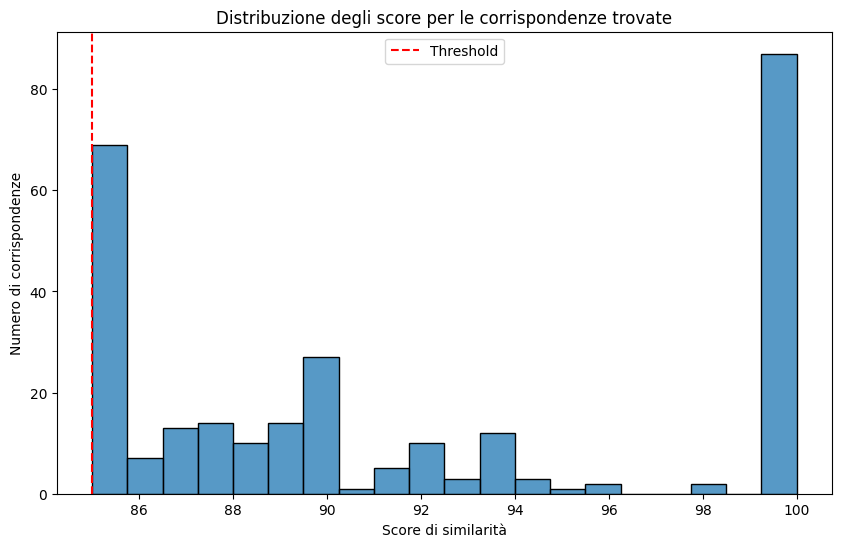

In [16]:
# Conteggio delle corrispondenze tra anagrafica_Ragione sociale e crunchbase_Organization Name

# Filtriamo le righe dove entrambi i campi non sono null
matched_companies = df_merged[
    pd.notna(df_merged['anagrafica_Ragione sociale']) & 
    pd.notna(df_merged['crunchbase_Organization Name'])
]

# Contiamo quante corrispondenze abbiamo trovato
total_matches = len(matched_companies)
total_anagrafica = df_merged['anagrafica_Ragione sociale'].notna().sum()
total_crunchbase = df_merged['crunchbase_Organization Name'].notna().sum()

print(f"Totale aziende con corrispondenza tra i due database: {total_matches}")
print(f"Totale aziende nel database anagrafica: {total_anagrafica}")
print(f"Totale aziende nel database crunchbase: {total_crunchbase}")
print(f"Percentuale di aziende anagrafica con match: {(total_matches / total_anagrafica * 100):.2f}%")
print(f"Percentuale di aziende crunchbase con match: {(total_matches / total_crunchbase * 100):.2f}%")

# Visualizziamo alcuni esempi di corrispondenze con i relativi score
print("\nEsempi di corrispondenze trovate (ordinate per score):")
display(matched_companies[['company_id', 'anagrafica_Ragione sociale', 
                          'crunchbase_Organization Name', 'similarity_score']]
       .sort_values(by='similarity_score', ascending=False).head(10))

# Distribuzione degli score per le corrispondenze trovate
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(matched_companies['similarity_score'], bins=20)
plt.title('Distribuzione degli score per le corrispondenze trovate')
plt.xlabel('Score di similarità')
plt.ylabel('Numero di corrispondenze')
plt.axvline(x=85, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.show()

In [17]:
# Save the df_merged DataFrame to a CSV file in the 'data' folder
df_merged.to_csv('data/df_merged.csv', index=False)

In [18]:
def extract_unmatched_crunchbase_locations():
    """
    Estrae gli Headquarters Location dal database Crunchbase per le aziende
    che sono presenti solo in Crunchbase (senza corrispondenza in anagrafica).
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame contenente Organization Name e Headquarters Location
        delle aziende che sono solo in Crunchbase
    """
    # Filtriamo le righe dove c'è un valore in crunchbase_Organization Name
    # ma non in anagrafica_Ragione sociale
    unmatched_cb = df_merged[
        pd.notna(df_merged['crunchbase_Organization Name']) & 
        pd.isna(df_merged['anagrafica_Ragione sociale'])
    ].copy()
    
    # Selezioniamo solo le colonne di interesse
    result = unmatched_cb[['crunchbase_Organization Name', 'crunchbase_Headquarters Location']]
    
    # Rinominiamo le colonne per maggiore chiarezza
    result = result.rename(columns={
        'crunchbase_Organization Name': 'Organization Name',
        'crunchbase_Headquarters Location': 'Headquarters Location'
    })
    
    # Riordiniamo e resettiamo l'indice
    result = result.sort_values(by='Organization Name').reset_index(drop=True)
    
    return result

# Eseguiamo la funzione e mostriamo i risultati
unmatched_locations = extract_unmatched_crunchbase_locations()

# Statistiche sulle sedi non corrispondenti
print(f"Totale organizzazioni solo in Crunchbase (senza match in anagrafica): {len(unmatched_locations)}")

# Contiamo la distribuzione delle sedi (top 10)
if 'Headquarters Location' in unmatched_locations.columns and not unmatched_locations.empty:
    location_counts = unmatched_locations['Headquarters Location'].value_counts().head(10)
    print("\nTop 10 sedi delle organizzazioni non corrispondenti:")
    display(location_counts)
    
    # Percentuale di valori mancanti nella colonna Headquarters Location
    missing_pct = unmatched_locations['Headquarters Location'].isna().mean() * 100
    print(f"\nPercentuale di valori mancanti nella colonna 'Headquarters Location': {missing_pct:.2f}%")

# Mostriamo i primi risultati
print("\nEsempi di organizzazioni solo in Crunchbase:")
display(unmatched_locations.head(10))

KeyError: "['crunchbase_Headquarters Location'] not in index"

In [ ]:
def get_crunchbase_only_companies():
    """
    Estrae i nomi delle aziende che sono presenti solo nel database Crunchbase
    e non hanno corrispondenza nel database Anagrafica.
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame contenente solo i nomi delle aziende presenti esclusivamente in Crunchbase
    """
    # Filtriamo le righe dove c'Ã¨ un valore in crunchbase_Organization Name
    # ma non in anagrafica_Ragione sociale
    crunchbase_only = df_merged[
        pd.notna(df_merged['crunchbase_Organization Name']) & 
        pd.isna(df_merged['anagrafica_Ragione sociale'])
    ].copy()
    
    # Selezioniamo solo la colonna con i nomi delle organizzazioni
    result = crunchbase_only[['crunchbase_Organization Name']].copy()
    
    # Rinominiamo la colonna per maggiore chiarezza
    result = result.rename(columns={
        'crunchbase_Organization Name': 'Organization Name'
    })
    
    # Rimuoviamo eventuali duplicati
    result = result.drop_duplicates().reset_index(drop=True)
    
    # Riordiniamo alfabeticamente
    result = result.sort_values(by='Organization Name').reset_index(drop=True)
    
    return result

# Eseguiamo la funzione e mostriamo i risultati
crunchbase_only_companies = get_crunchbase_only_companies()

# Statistiche sulle aziende
print(f"Totale aziende presenti solo in Crunchbase (senza match in anagrafica): {len(crunchbase_only_companies)}")

# Mostriamo i primi risultati
print("\nEsempi di aziende solo in Crunchbase:")
display(crunchbase_only_companies.head(15))

# Opzionale: verifichiamo la coda della lista
print("\nUltime aziende della lista:")
display(crunchbase_only_companies.tail(5))

Totale aziende presenti solo in Crunchbase (senza match in anagrafica): 3418

Esempi di aziende solo in Crunchbase:


,Organization Name
0,#00F Agency
1,(re)BALANCE
2,010 Films
3,01Bee
4,1000Farmacie
5,100Grammi
6,10punto10
7,1C ERP
8,20ACTION
9,20energy



Ultime aziende della lista:


,Organization Name
3413,Árchee Progettazione Integrata
3414,Élite Odontoiatrica
3415,Éyra Cosmetics
3416,àdest legal & tax
3417,‍Ulisse


In [ ]:
# Save the crunchbase_only_companies DataFrame to a CSV file in the 'data' folder
crunchbase_only_companies.to_csv(f"data/{df_non_unite}", index=False)